In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [67]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
datapath = "../data/data/v2.0/"
import csv
from collections import defaultdict
import seaborn as sn
from numpy.random import default_rng

In [68]:
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

In [69]:
english_dataframe = pd.read_csv(datapath+"hipe2020/en/HIPE-2022-v2.0-hipe2020-dev-en.tsv", sep = '\t', header = 0, engine="python", comment='#', quoting=csv.QUOTE_NONE)
# english_dataframe = pd.read_csv(datapath+"hipe2020/fr/HIPE-2022-v2.0-hipe2020-dev-fr.tsv", sep = '\t', header = 0, engine="python", comment='#', quoting=csv.QUOTE_NONE)
# english_dataframe = pd.read_csv(datapath+"hipe2020/de/HIPE-2022-v2.0-hipe2020-dev-de.tsv", sep = '\t', header = 0, engine="python", comment='#', quoting=csv.QUOTE_NONE)

In [99]:
misc_list = english_dataframe["MISC"].to_list()

In [100]:
tokens = english_dataframe["TOKEN"].tolist()
labels = english_dataframe["NE-COARSE-LIT"].tolist()

In [101]:
print(len(misc_list))
print(len(tokens))
print(len(labels))

32671
32671
32671


In [102]:
data_sents = []
sentence = []
for idx, item in enumerate(misc_list):
    token = tokens[idx]
    if isinstance(token, float): #null in the tsv is taken as a nan value
        token = "null"
    label = labels[idx]
    sentence.append((token,label))
    if "EndOfSentence" in item:
        data_sents.append(sentence)
        sentence = []
data_sents = np.array(data_sents, dtype=object)

In [103]:
%%time
split = 0.3
train_sents = np.random.choice(data_sents, size=int(len(data_sents)*split), replace=False)
test_sents = [sent for sent in data_sents if sent not in train_sents]

Wall time: 69.8 ms


c:\Users\karst\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [104]:
train_sents[0]

[('ehende', 'O'), ('lant', 'O'), ('.', 'O')]

In [105]:
def word2features(sent, i):
    word = sent[i][0]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word contains number': any(char.isdigit() for char in word),
        "word contains symbol": not word.isalpha(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

In [106]:
sent2features(train_sents[0])[0]
# print(train_sents[0])

{'bias': 1.0,
 'word.lower()': 'ehende',
 'word[-3:]': 'nde',
 'word[-2:]': 'de',
 'word.isupper()': False,
 'word.istitle()': False,
 'word contains number': False,
 'word contains symbol': False,
 'BOS': True,
 '+1:word.lower()': 'lant',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False}

In [107]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

Wall time: 136 ms


In [108]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass
predictions = crf.predict(X_test)

Wall time: 1.52 s


In [109]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-loc',
 'I-loc',
 'B-pers',
 'I-pers',
 'B-prod',
 'I-prod',
 'B-org',
 'I-org',
 'B-time',
 'I-time']

In [110]:
y_pred = crf.predict(X_test)
f_1 = metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)
precision = metrics.flat_precision_score(y_test, y_pred,
                      average='weighted', labels=labels)
recall = metrics.flat_recall_score(y_test, y_pred,
                      average='weighted', labels=labels)

print(f"f1: {f_1}")
print(f"p: {precision}")
print(f"r: {recall}")

f1: 0.6020351911305483
p: 0.8806609689459702
r: 0.4654340836012862


In [111]:
test_itterations = 5
prob_itterations = 10
performance_dict = defaultdict(lambda:{"avg_recall": [], "avg_prec": [], "avg_f1":[]})

for test_itter in range(test_itterations):
    test_sents = np.random.choice(data_sents, size=int(len(data_sents)*0.1), replace=False)
    possible_train_sents = [sent for sent in data_sents if sent not in test_sents]
    possible_train_sents = np.array(possible_train_sents, dtype=object)
    X_test = [sent2features(s) for s in test_sents]
    y_test = [sent2labels(s) for s in test_sents]
    for prob in np.arange(1/9, 10/9, step=1/9):
        for prob_itter in range(prob_itterations):
            print(f"test itter {test_itter}, prob itter: {prob_itter}, prob: {prob*9/10}")
            train_sents = np.random.choice(possible_train_sents, size=int(len(possible_train_sents)*prob), replace=False)
            X_train = [sent2features(s) for s in train_sents]
            y_train = [sent2labels(s) for s in train_sents]


            crf = sklearn_crfsuite.CRF(
                algorithm='lbfgs',
                c1=0.1,
                c2=0.1,
                max_iterations=100,
                all_possible_transitions=True
            )
            try:
                crf.fit(X_train, y_train)
            except AttributeError:
                pass
            y_pred = crf.predict(X_test)
            f_1 = metrics.flat_f1_score(y_test, y_pred,
                                average='weighted', labels=labels, zero_division = 0)
            precision = metrics.flat_precision_score(y_test, y_pred,
                                average='weighted', labels=labels, zero_division = 0)
            recall = metrics.flat_recall_score(y_test, y_pred,
                                average='weighted', labels=labels, zero_division = 0)
            performance_dict[prob]["avg_recall"].append(recall)
            performance_dict[prob]["avg_prec"].append(precision)
            performance_dict[prob]["avg_f1"].append(f_1)

test itter 0, prob itter: 0, prob: 0.1


c:\Users\karst\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


test itter 0, prob itter: 1, prob: 0.1
test itter 0, prob itter: 2, prob: 0.1
test itter 0, prob itter: 3, prob: 0.1
test itter 0, prob itter: 4, prob: 0.1
test itter 0, prob itter: 5, prob: 0.1
test itter 0, prob itter: 6, prob: 0.1
test itter 0, prob itter: 7, prob: 0.1
test itter 0, prob itter: 8, prob: 0.1
test itter 0, prob itter: 9, prob: 0.1
test itter 0, prob itter: 0, prob: 0.2
test itter 0, prob itter: 1, prob: 0.2
test itter 0, prob itter: 2, prob: 0.2
test itter 0, prob itter: 3, prob: 0.2
test itter 0, prob itter: 4, prob: 0.2
test itter 0, prob itter: 5, prob: 0.2
test itter 0, prob itter: 6, prob: 0.2
test itter 0, prob itter: 7, prob: 0.2
test itter 0, prob itter: 8, prob: 0.2
test itter 0, prob itter: 9, prob: 0.2
test itter 0, prob itter: 0, prob: 0.3
test itter 0, prob itter: 1, prob: 0.3
test itter 0, prob itter: 2, prob: 0.3
test itter 0, prob itter: 3, prob: 0.3
test itter 0, prob itter: 4, prob: 0.3
test itter 0, prob itter: 5, prob: 0.3
test itter 0, prob itter:

c:\Users\karst\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


test itter 1, prob itter: 0, prob: 0.1
test itter 1, prob itter: 1, prob: 0.1
test itter 1, prob itter: 2, prob: 0.1
test itter 1, prob itter: 3, prob: 0.1
test itter 1, prob itter: 4, prob: 0.1
test itter 1, prob itter: 5, prob: 0.1
test itter 1, prob itter: 6, prob: 0.1
test itter 1, prob itter: 7, prob: 0.1
test itter 1, prob itter: 8, prob: 0.1
test itter 1, prob itter: 9, prob: 0.1
test itter 1, prob itter: 0, prob: 0.2
test itter 1, prob itter: 1, prob: 0.2
test itter 1, prob itter: 2, prob: 0.2
test itter 1, prob itter: 3, prob: 0.2
test itter 1, prob itter: 4, prob: 0.2
test itter 1, prob itter: 5, prob: 0.2
test itter 1, prob itter: 6, prob: 0.2
test itter 1, prob itter: 7, prob: 0.2
test itter 1, prob itter: 8, prob: 0.2
test itter 1, prob itter: 9, prob: 0.2
test itter 1, prob itter: 0, prob: 0.3
test itter 1, prob itter: 1, prob: 0.3
test itter 1, prob itter: 2, prob: 0.3
test itter 1, prob itter: 3, prob: 0.3
test itter 1, prob itter: 4, prob: 0.3
test itter 1, prob itter:

c:\Users\karst\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


test itter 2, prob itter: 0, prob: 0.1
test itter 2, prob itter: 1, prob: 0.1
test itter 2, prob itter: 2, prob: 0.1
test itter 2, prob itter: 3, prob: 0.1
test itter 2, prob itter: 4, prob: 0.1
test itter 2, prob itter: 5, prob: 0.1
test itter 2, prob itter: 6, prob: 0.1
test itter 2, prob itter: 7, prob: 0.1
test itter 2, prob itter: 8, prob: 0.1
test itter 2, prob itter: 9, prob: 0.1
test itter 2, prob itter: 0, prob: 0.2
test itter 2, prob itter: 1, prob: 0.2
test itter 2, prob itter: 2, prob: 0.2
test itter 2, prob itter: 3, prob: 0.2
test itter 2, prob itter: 4, prob: 0.2
test itter 2, prob itter: 5, prob: 0.2
test itter 2, prob itter: 6, prob: 0.2
test itter 2, prob itter: 7, prob: 0.2
test itter 2, prob itter: 8, prob: 0.2
test itter 2, prob itter: 9, prob: 0.2
test itter 2, prob itter: 0, prob: 0.3
test itter 2, prob itter: 1, prob: 0.3
test itter 2, prob itter: 2, prob: 0.3
test itter 2, prob itter: 3, prob: 0.3
test itter 2, prob itter: 4, prob: 0.3
test itter 2, prob itter:

c:\Users\karst\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


test itter 3, prob itter: 0, prob: 0.1
test itter 3, prob itter: 1, prob: 0.1
test itter 3, prob itter: 2, prob: 0.1
test itter 3, prob itter: 3, prob: 0.1
test itter 3, prob itter: 4, prob: 0.1
test itter 3, prob itter: 5, prob: 0.1
test itter 3, prob itter: 6, prob: 0.1
test itter 3, prob itter: 7, prob: 0.1
test itter 3, prob itter: 8, prob: 0.1
test itter 3, prob itter: 9, prob: 0.1
test itter 3, prob itter: 0, prob: 0.2
test itter 3, prob itter: 1, prob: 0.2
test itter 3, prob itter: 2, prob: 0.2
test itter 3, prob itter: 3, prob: 0.2
test itter 3, prob itter: 4, prob: 0.2
test itter 3, prob itter: 5, prob: 0.2
test itter 3, prob itter: 6, prob: 0.2
test itter 3, prob itter: 7, prob: 0.2
test itter 3, prob itter: 8, prob: 0.2
test itter 3, prob itter: 9, prob: 0.2
test itter 3, prob itter: 0, prob: 0.3
test itter 3, prob itter: 1, prob: 0.3
test itter 3, prob itter: 2, prob: 0.3
test itter 3, prob itter: 3, prob: 0.3
test itter 3, prob itter: 4, prob: 0.3
test itter 3, prob itter:

c:\Users\karst\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


test itter 4, prob itter: 0, prob: 0.1
test itter 4, prob itter: 1, prob: 0.1
test itter 4, prob itter: 2, prob: 0.1
test itter 4, prob itter: 3, prob: 0.1
test itter 4, prob itter: 4, prob: 0.1
test itter 4, prob itter: 5, prob: 0.1
test itter 4, prob itter: 6, prob: 0.1
test itter 4, prob itter: 7, prob: 0.1
test itter 4, prob itter: 8, prob: 0.1
test itter 4, prob itter: 9, prob: 0.1
test itter 4, prob itter: 0, prob: 0.2
test itter 4, prob itter: 1, prob: 0.2
test itter 4, prob itter: 2, prob: 0.2
test itter 4, prob itter: 3, prob: 0.2
test itter 4, prob itter: 4, prob: 0.2
test itter 4, prob itter: 5, prob: 0.2
test itter 4, prob itter: 6, prob: 0.2
test itter 4, prob itter: 7, prob: 0.2
test itter 4, prob itter: 8, prob: 0.2
test itter 4, prob itter: 9, prob: 0.2
test itter 4, prob itter: 0, prob: 0.3
test itter 4, prob itter: 1, prob: 0.3
test itter 4, prob itter: 2, prob: 0.3
test itter 4, prob itter: 3, prob: 0.3
test itter 4, prob itter: 4, prob: 0.3
test itter 4, prob itter:

In [112]:
import pickle
map_path = "C:/Users/karst/OneDrive/Documenten/uni/jaar 3 semester 2, het semester dat ik opgaf/Bachelor-graduation-project/code/saved runs/"
with open(map_path + 'performance_dict_max_depth_german.pkl', 'wb') as outp:
    pickle.dump(dict(performance_dict), outp)

In [113]:
for key in performance_dict:
    print(key*9/10)
    for category in performance_dict[key]:
        print(f"{category}: {np.mean(performance_dict[key][category])}")
    print("----------------")

0.1
avg_recall: 0.1977380935830714
avg_prec: 0.6886053550394415
avg_f1: 0.28977212442553557
----------------
0.2
avg_recall: 0.36447075734154116
avg_prec: 0.8087083887924487
avg_f1: 0.48114497825030594
----------------
0.3
avg_recall: 0.4729191975757544
avg_prec: 0.8572313881428099
avg_f1: 0.5912668330381519
----------------
0.4
avg_recall: 0.5827569484384746
avg_prec: 0.902851018527778
avg_f1: 0.6913374851353485
----------------
0.5
avg_recall: 0.6993519981705176
avg_prec: 0.9273163868872639
avg_f1: 0.7864288693835675
----------------
0.6000000000000001
avg_recall: 0.7426182547395612
avg_prec: 0.9444960161512954
avg_f1: 0.8216280479424514
----------------
0.7
avg_recall: 0.8381518374979171
avg_prec: 0.9677987267093744
avg_f1: 0.893355344799991
----------------
0.8
avg_recall: 0.8963531741112277
avg_prec: 0.9781566165284292
avg_f1: 0.9317460652148738
----------------
0.9
avg_recall: 0.9758700712422613
avg_prec: 0.997021016452612
avg_f1: 0.9857071750904612
----------------


In [4]:
import matplotlib.pyplot as plt

In [2]:
import pickle
map_path = "C:/Users/karst/OneDrive/Documenten/uni/jaar 3 semester 2, het semester dat ik opgaf/Bachelor-graduation-project/code/saved runs/"

In [62]:
with open(map_path + 'performance_dict_german.pkl', 'rb') as inp:
    performance_dict = pickle.load(inp)

In [63]:
recall_plot_list = []
precision_plot_list = []
f1_plot_list = []
for key in performance_dict:
    recall_plot_list.append(performance_dict[key]["avg_recall"])
    precision_plot_list.append(performance_dict[key]["avg_prec"])
    f1_plot_list.append(performance_dict[key]["avg_f1"])

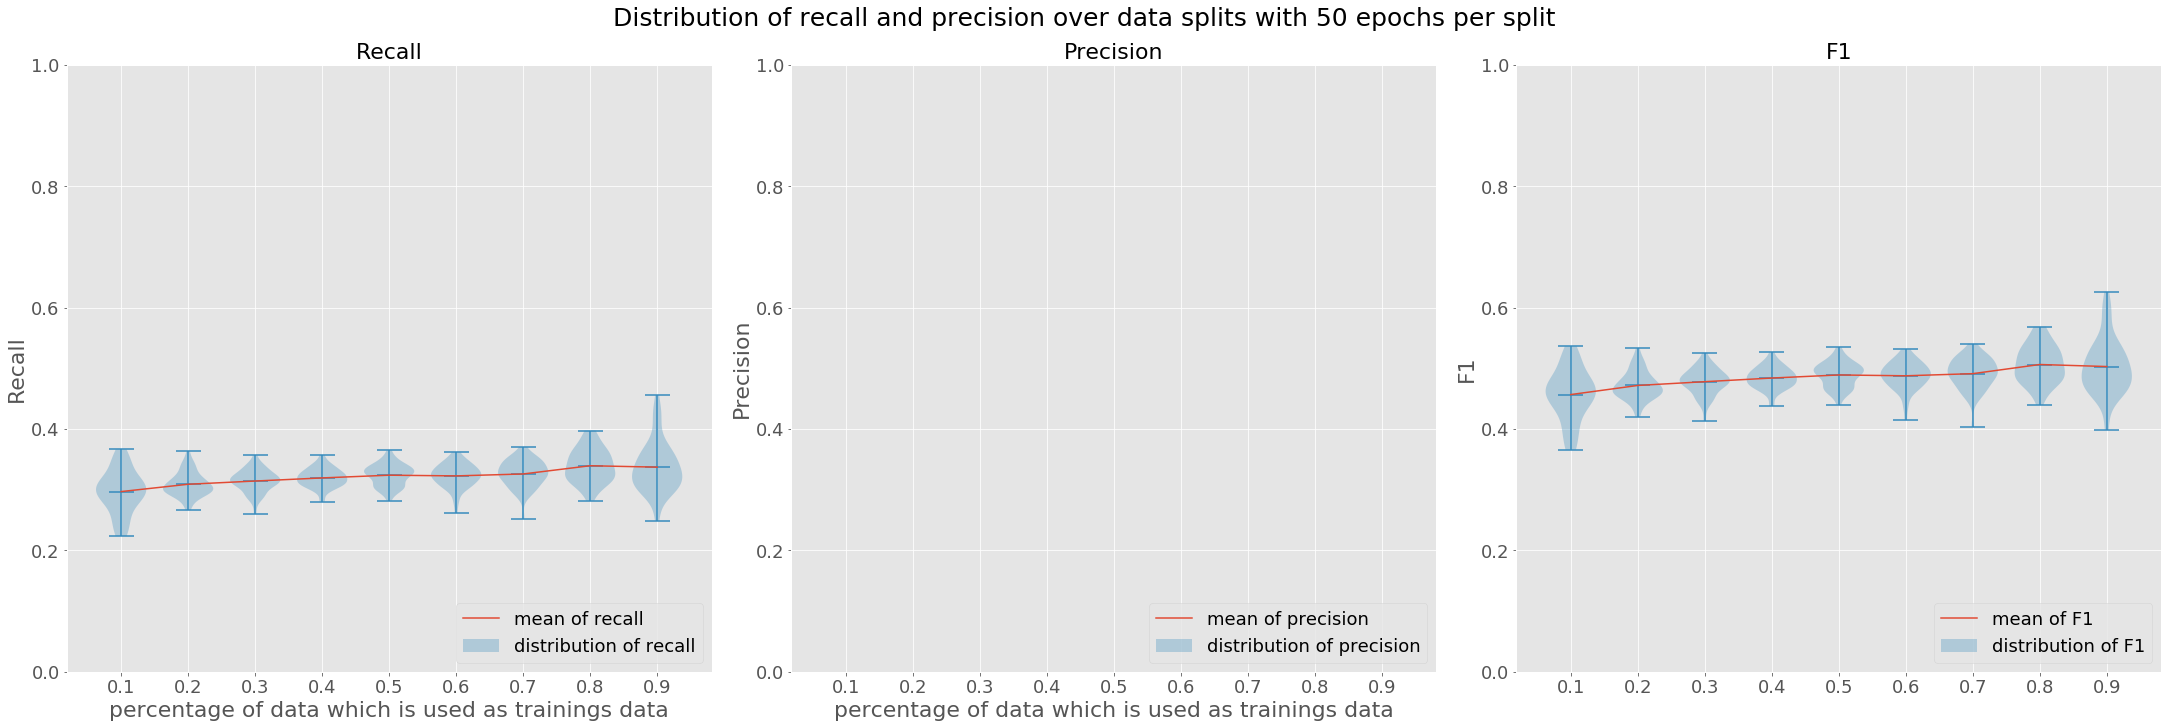

In [48]:
small_size = 18
medium_size = 22
fig, axs = plt.subplots(1,3 , constrained_layout=True, figsize=(30,10))
# fig = plt.figure(figsize=(20,10))
# fig.suptitle("Distribution of recall and precision over data splits with 50 epochs per split", fontsize= 16)
# axs[0]= fig.add_axes([0,0,0.5,1])
labels = [i/10 for i in range(1,10)]

#recall
axs[0].plot([1,2,3,4,5,6,7,8,9],np.mean(recall_plot_list, axis=1))
axs[0].violinplot(recall_plot_list, showmeans=True, widths=0.75)
axs[0].set_xticks([1,2,3,4,5,6,7,8,9])
axs[0].set_xticklabels(labels)
axs[0].set_ylim(0,1)
axs[0].set_xlabel(xlabel="percentage of data which is used as trainings data")
axs[0].set_ylabel(ylabel="Recall")
axs[0].legend(["mean of recall","distribution of recall"], loc="lower right", fontsize = small_size)
axs[0].set_title("Recall")


#prec
axs[1].plot([1,2,3,4,5,6,7,8,9],np.mean(precision_plot_list, axis=1))
axs[1].violinplot(precision_plot_list, showmeans=True, widths=0.75)
axs[1].set_xticks([1,2,3,4,5,6,7,8,9])
axs[1].set_xticklabels(labels)
axs[1].set_ylim(0,1)
axs[1].set_xlabel(xlabel="percentage of data which is used as trainings data")
axs[1].set_ylabel(ylabel="Precision")
axs[1].legend(["mean of precision","distribution of precision"], loc="lower right", fontsize = small_size)
axs[1].set_title("Precision")

#f1
axs[2].plot([1,2,3,4,5,6,7,8,9],np.mean(f1_plot_list, axis=1))
axs[2].violinplot(f1_plot_list, showmeans=True, widths=0.75)
axs[2].set_xticks([1,2,3,4,5,6,7,8,9])
axs[2].set_xticklabels(labels)
axs[2].set_ylim(0,1)
# axs[1].set_xlabel(xlabel="percentage of data which is used as trainings data")
axs[2].set_ylabel(ylabel="F1")
axs[2].legend(["mean of F1","distribution of F1"], loc="lower right", fontsize= small_size)
axs[2].set_title("F1")

#main
fig.suptitle("Distribution of recall and precision over data splits with 50 epochs per split", fontsize= 25)

# small_size = 18
# medium_size = 22
plt.rc("xtick", labelsize = small_size)
plt.rc("ytick", labelsize = small_size)
plt.rc("axes", labelsize = medium_size)
plt.rc("axes", titlesize = medium_size)
# plt.rc("legend", labelsize= small_size)


plt.show()

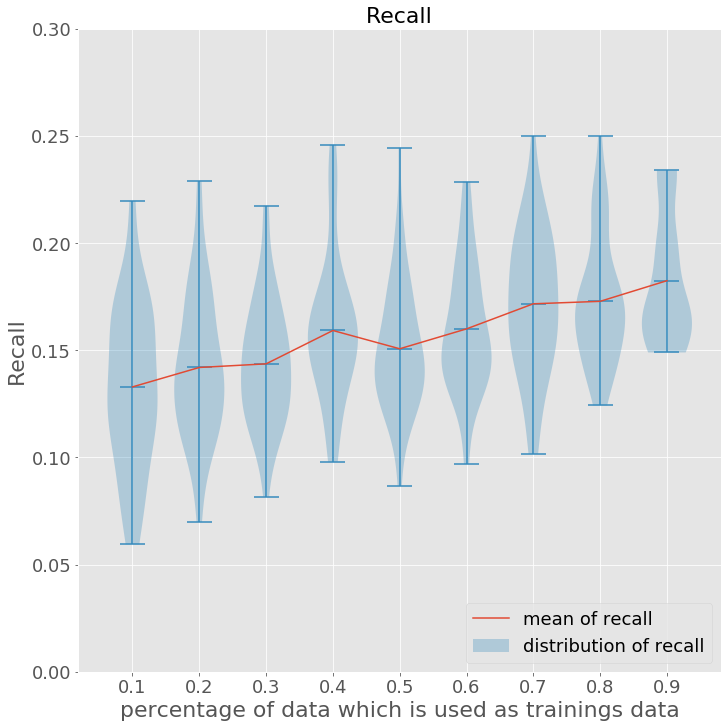

In [65]:
small_size = 18
medium_size = 22
fig, axs = plt.subplots(1,1 , constrained_layout=True, figsize=(10,10))
# fig = plt.figure(figsize=(20,10))
# fig.suptitle("Distribution of recall and precision over data splits with 50 epochs per split", fontsize= 16)
# axs[0]= fig.add_axes([0,0,0.5,1])
labels = [i/10 for i in range(1,10)]

#recall
axs.plot([1,2,3,4,5,6,7,8,9],np.mean(recall_plot_list, axis=1))
axs.violinplot(recall_plot_list, showmeans=True, widths=0.75)
axs.set_xticks([1,2,3,4,5,6,7,8,9])
axs.set_xticklabels(labels)
axs.set_ylim(0,1)
axs.set_xlabel(xlabel="percentage of data which is used as trainings data")
axs.set_ylabel(ylabel="Recall")
axs.legend(["mean of recall","distribution of recall"], loc="lower right", fontsize = small_size)
axs.set_ylim(0, 0.3)
axs.set_title("Recall")

# small_size = 18
# medium_size = 22
plt.rc("xtick", labelsize = small_size)
plt.rc("ytick", labelsize = small_size)
plt.rc("axes", labelsize = medium_size)
plt.rc("axes", titlesize = medium_size)
# plt.rc("legend", labelsize= small_size)


plt.show()

In [1]:
print(precision_plot_list)

NameError: name 'precision_plot_list' is not defined